In [ ]:
!pip install OpenEXR numpy pillow

In [ ]:
!pip install opencv-python==4.5.4.58

In [ ]:
import OpenEXR
import Imath
import numpy as np
from PIL import Image
import cv2
import imageio.v2 as imageio
from PIL import Image
import numpy as np
from keras.preprocessing.image import img_to_array
#from keras import backend as K
#from tensorflow.keras.utils import img_to_array
import tensorflow.keras.backend as K

from keras.layers import Layer
from keras.layers import Input
from keras.layers import Convolution2D
from keras.layers import Activation, Reshape
from keras.layers import BatchNormalization
from keras.layers import add
from keras.layers import Dropout
from keras.models import Model
import keras.optimizers
import argparse
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import MaxPooling2D, UpSampling2D


In [ ]:
def segnet(input_shape, n_labels, kernel=3, pool_size=(2, 2), output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)
    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    residual = conv_1
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Dropout(0.3)(conv_2)
    conv_2 = Activation("relu")(conv_2)
    residual = Convolution2D(64, (kernel, kernel), padding="same")(residual)
    residual = BatchNormalization()(residual)
    conv_2 = add([conv_2,residual])


    pool_1 = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding="same")(conv_2)

    residual = pool_1
    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Dropout(0.3)(conv_4)
    conv_4 = Activation("relu")(conv_4)
    residual = Convolution2D(128, (kernel, kernel), padding="same")(residual)
    residual = BatchNormalization()(residual)
    conv_4 = add([conv_4,residual])

    pool_2 = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding="same")(conv_4)

    residual = pool_2
    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Dropout(0.3)(conv_6)
    conv_6 = Activation("relu")(conv_6)
    residual = Convolution2D(256, (kernel, kernel), padding="same")(residual)
    residual = BatchNormalization()(residual)
    conv_6 = add([conv_6,residual])

    pool_3 = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding="same")(conv_6)

    residual = pool_3
    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Dropout(0.3)(conv_8)
    conv_8 = Activation("relu")(conv_8)
    residual = Convolution2D(512, (kernel, kernel), padding="same")(residual)
    residual = BatchNormalization()(residual)
    conv_8 = add([conv_8,residual])

    pool_4 = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding="same")(conv_8)

    residual = pool_4
    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Dropout(0.3)(conv_11)
    conv_11 = Activation("relu")(conv_11)
    residual = Convolution2D(512, (kernel, kernel), padding="same")(residual)
    residual = BatchNormalization()(residual)
    conv_11 = add([conv_11,residual])

    pool_5 = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding="same")(conv_11)

    # decoder
    unpool_1 = UpSampling2D(size=pool_size, interpolation="bilinear")(pool_5)


    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Dropout(0.3)(conv_14)
    conv_14 = Activation("relu")(conv_14)

    unpool_2 = UpSampling2D(size=pool_size, interpolation="bilinear")(conv_14)

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_17)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Dropout(0.3)(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = UpSampling2D(size=pool_size, interpolation="bilinear")(conv_19)

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(128, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Dropout(0.3)(conv_21)
    conv_21 = Activation("relu")(conv_21)


    unpool_4 = UpSampling2D(size=pool_size, interpolation="bilinear")(conv_21)

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Dropout(0.3)(conv_24)
    conv_24 = Activation("relu")(conv_24)


    unpool_5 = UpSampling2D(size=pool_size, interpolation="bilinear")(conv_24)

    residual = unpool_5
    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    conv_26 = Reshape(
        (input_shape[0], input_shape[1], n_labels),
        input_shape=(input_shape[0], input_shape[1], n_labels),
    )(conv_26)
    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model


model = segnet((224,224,3), n_labels=5 ,kernel=3, pool_size=(2,2), output_mode="softmax")

print(model.summary())

print("tf.__version__ is", tf.__version__)

In [ ]:
def exr_to_jpg(path):
    exr_file = OpenEXR.InputFile(path)

    header = exr_file.header()
    data_window = header['dataWindow']
    width = data_window.max.x - data_window.min.x + 1
    height = data_window.max.y - data_window.min.y + 1


    channels = ["R","G","B"]
    data = [np.frombuffer(exr_file.channel(channel, Imath.PixelType(Imath.PixelType.FLOAT)), dtype=np.float32)
                for channel in channels]

    array = [np.clip(channel.reshape(height, width)/(np.max(channel)+ 1e-7),0,1).astype(np.float32) for channel in data]

    image = np.dstack(array)
    return image

def category_label(labels, dims, n_labels):
    x = np.zeros([dims[0], dims[1], n_labels])
    for i in range(dims[0]):
        for j in range(dims[1]):
            f=int(labels[i,j])
            x[i, j, f] = 1
    return x
def colorize(img):
    w=img.shape[0]
    h=img.shape[1]
    z=img.shape[2]
    l=np.zeros((w,h,3))
    for i in range(w):
        for j in range(h):
            if img[i,j,0]==1:
                l[i,j,0]=0
                l[i,j,1]=0
                l[i,j,2]=0
            elif img[i,j,1]==1:
                l[i,j,0]=255
                l[i,j,1]=0
                l[i,j,2]=0
            elif img[i,j,2]==1:
                l[i,j,0]=0
                l[i,j,1]=255
                l[i,j,2]=0
            elif img[i,j,3]==1:
                l[i,j,0]=0
                l[i,j,1]=0
                l[i,j,2]=255
            elif img[i,j,4]==1:
                l[i,j,0]=238
                l[i,j,1]=197
                l[i,j,2]=145
    return l

def class_pixels(img):
    w=img.shape[0]
    h=img.shape[1]
    z=img.shape[2]
    l=np.zeros((w,h,z))
    for i in range(w):
        for j in range(h):
            for f in range(z-1):
                if img[i,j,f]==np.max([img[i,j,0],img[i,j,1],img[i,j,2],img[i,j,3],img[i,j,4]]):
                    l[i,j,f]=1
    return l


In [ ]:
import concurrent.futures

def process_file(index, img_dir, mask_dir, dims, n_labels):
    img_path = img_dir[index]
    original_img = exr_to_jpg(img_path)
    array_img = img_to_array(original_img) / 255.0

    mask_path = mask_dir[index]
    original_mask = cv2.imread(mask_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    array_mask = category_label(original_mask[:, :, 0], dims, n_labels)

    return array_img, array_mask

def data_gen_small(img_dir, mask_dir, depth_dir, liste, batch_size, dims=(224, 224), n_labels=5):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        while True:
            ix = np.random.choice(liste, batch_size)
            results = list(executor.map(
                lambda index: process_file(index, img_dir, mask_dir, dims, n_labels), ix
            ))

            imgs, labels = zip(*results)
            yield np.array(imgs), np.array(labels)

In [ ]:
import os
rgb=[]
depth=[]
mask=[]
node=[]
for dirs,subdir,files in os.walk('/content/dataset of synthetic rgb-d plants/rgb_map'):
    for file_name in files:
      if file_name.endswith(".exr"):
            path_file=dirs+os.sep+file_name
            depth_file='/content/dataset of synthetic rgb-d plants/depth_map/profondeur_map/'+file_name
            mask_file='/content/dataset of synthetic rgb-d plants/semantic_map/segmentation2_map/'+file_name
            node_file='/content/dataset of synthetic rgb-d plants/nodes_map/internoeuds_map/'+file_name
            rgb.append(path_file)
            depth.append(depth_file)
            mask.append(mask_file)
            node.append(node_file)




liste=np.arange(1,10000)
np.random.shuffle(liste)

train_list=liste[0:8000]
val_list=liste[8000:9000]
test_list=liste[9000:9999]


train_gen = data_gen_small(rgb
,mask,depth,liste=train_list,batch_size=32,dims=(224,224),n_labels=5)
val_gen=data_gen_small(rgb
,mask,depth,liste=val_list,batch_size=32,dims=(224,224),n_labels=5)
test_gen = data_gen_small(rgb
,mask,depth,liste=test_list,batch_size=1,dims=(224,224),n_labels=5)


input_shape = (224, 224, 3)
output_shape = (224, 224, 5)
def train_gen_wrapper():
    return data_gen_small(rgb, mask, depth, liste=train_list, batch_size=16, dims=(224, 224), n_labels=5)
def val_gen_wrapper():
    return data_gen_small(rgb, mask, depth, liste=val_list, batch_size=16, dims=(224, 224), n_labels=5)
def test_gen_wrapper():
    return data_gen_small(rgb, mask, depth, liste=test_list, batch_size=1, dims=(224, 224), n_labels=5)

dataset = tf.data.Dataset.from_generator(
    train_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(16, *input_shape), dtype=tf.float32),
        tf.TensorSpec(shape=(16, *output_shape), dtype=tf.float32),
    )
)

val_dataset = tf.data.Dataset.from_generator(
    val_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(16, *input_shape), dtype=tf.float32),
        tf.TensorSpec(shape=(16, *output_shape), dtype=tf.float32),
    )
)


test_dataset = tf.data.Dataset.from_generator(
    test_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(1, *input_shape), dtype=tf.float32),
        tf.TensorSpec(shape=(1, *output_shape), dtype=tf.float32),
    )
)

In [ ]:
def dice_coef(y_true, y_pred):
    y_true = K.reshape(y_true, K.shape(y_pred))
    epsilon=1e-6
    axes = tuple(range(1, len(y_pred.shape)-1))
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)

    return K.mean((numerator + epsilon) / (denominator + epsilon))

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
model.compile(loss=dice_coef_loss, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy", dice_coef])

In [ ]:
dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
history = model.fit(
    dataset,
    steps_per_epoch=100,
    epochs=50,
    validation_data=val_dataset,
    validation_steps=20,
)


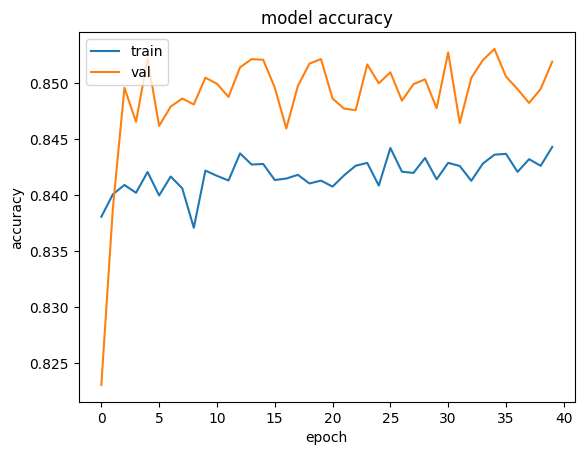

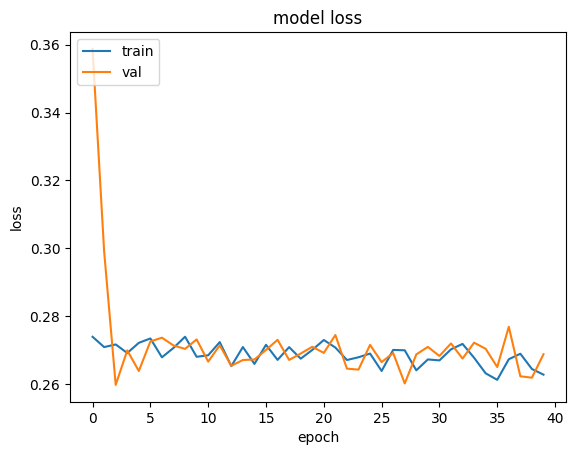

In [ ]:
plt.plot(history.history['accuracy'],markersize=20)
plt.plot(history.history['val_accuracy'], markersize=20)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# plotting of training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def convert_exr_to_rgb(exr_path):
    exr_file = OpenEXR.InputFile(exr_path)

    header = exr_file.header()
    data_window = header['dataWindow']
    width = data_window.max.x - data_window.min.x + 1
    height = data_window.max.y - data_window.min.y + 1

    channels = ['R', 'G', 'B']
    rgb_data = [np.frombuffer(exr_file.channel(channel, Imath.PixelType(Imath.PixelType.FLOAT)), dtype=np.float32)
                for channel in channels]

    rgb_array = [np.clip(channel.reshape(height, width) * 255, 0, 255).astype(np.uint8) for channel in rgb_data]

    # Создаем RGB изображение из каналов
    rgb_image = np.dstack(rgb_array)
    return rgb_image

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


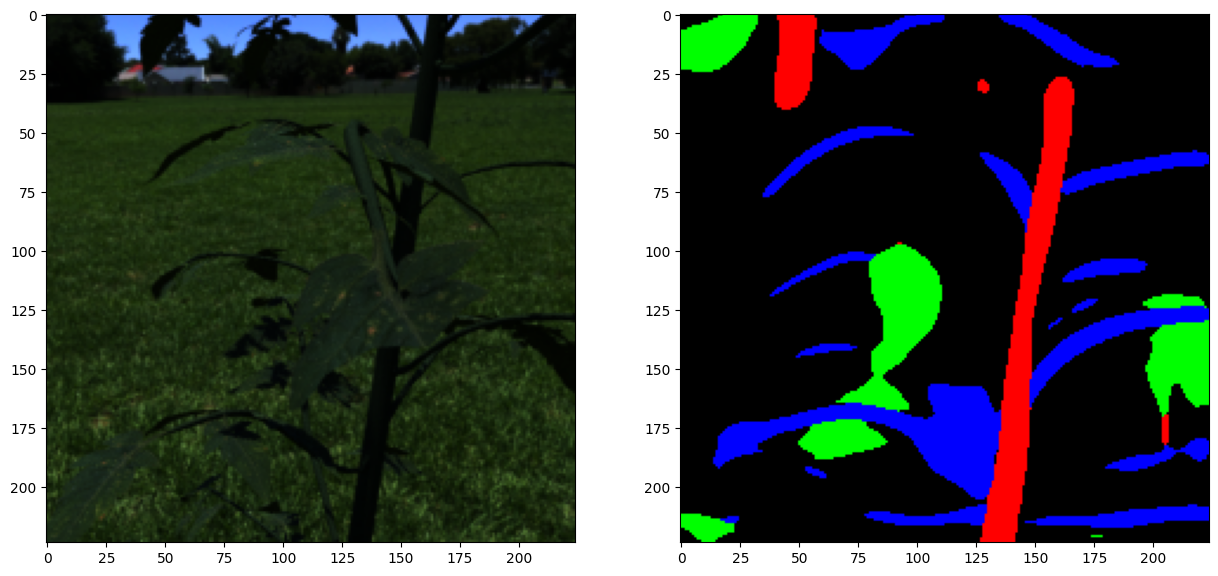

Original Image Shape: (224, 224, 3)
Predicted Shape: (224, 224, 5)
Class Pixels Shape: (224, 224, 5)
Colorized Output Shape: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


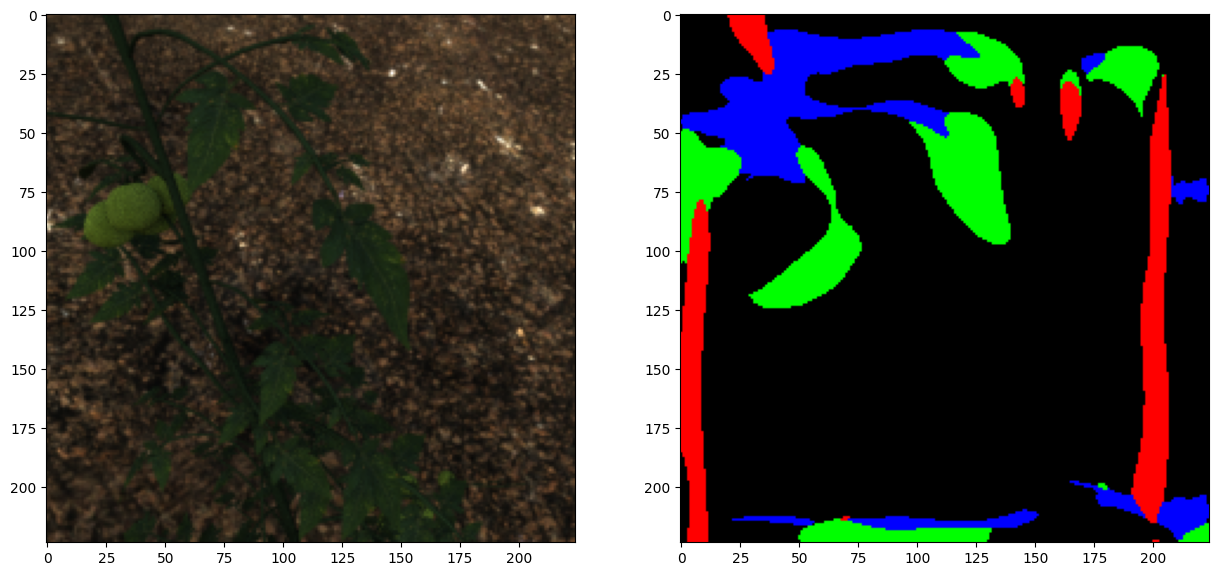

Original Image Shape: (224, 224, 3)
Predicted Shape: (224, 224, 5)
Class Pixels Shape: (224, 224, 5)
Colorized Output Shape: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


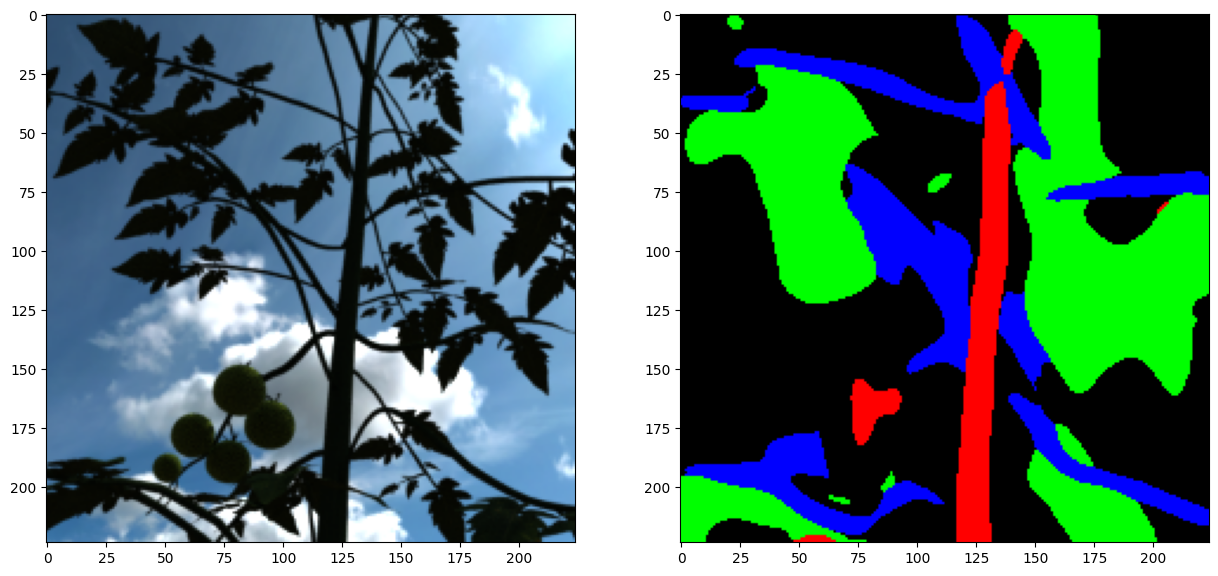

Original Image Shape: (224, 224, 3)
Predicted Shape: (224, 224, 5)
Class Pixels Shape: (224, 224, 5)
Colorized Output Shape: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


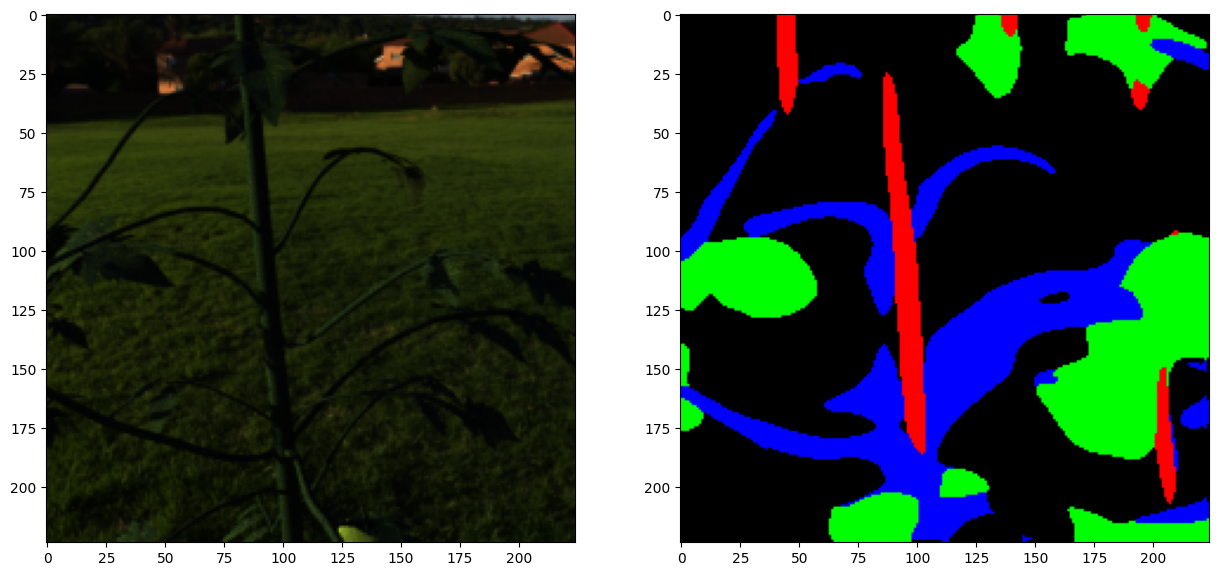

Original Image Shape: (224, 224, 3)
Predicted Shape: (224, 224, 5)
Class Pixels Shape: (224, 224, 5)
Colorized Output Shape: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


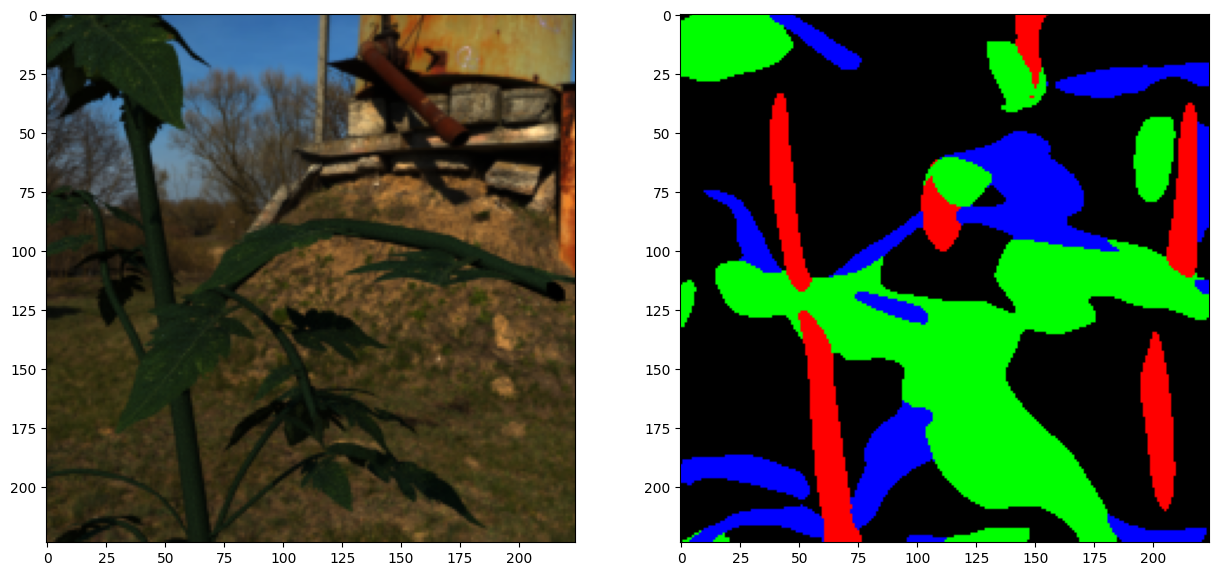

Original Image Shape: (224, 224, 3)
Predicted Shape: (224, 224, 5)
Class Pixels Shape: (224, 224, 5)
Colorized Output Shape: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


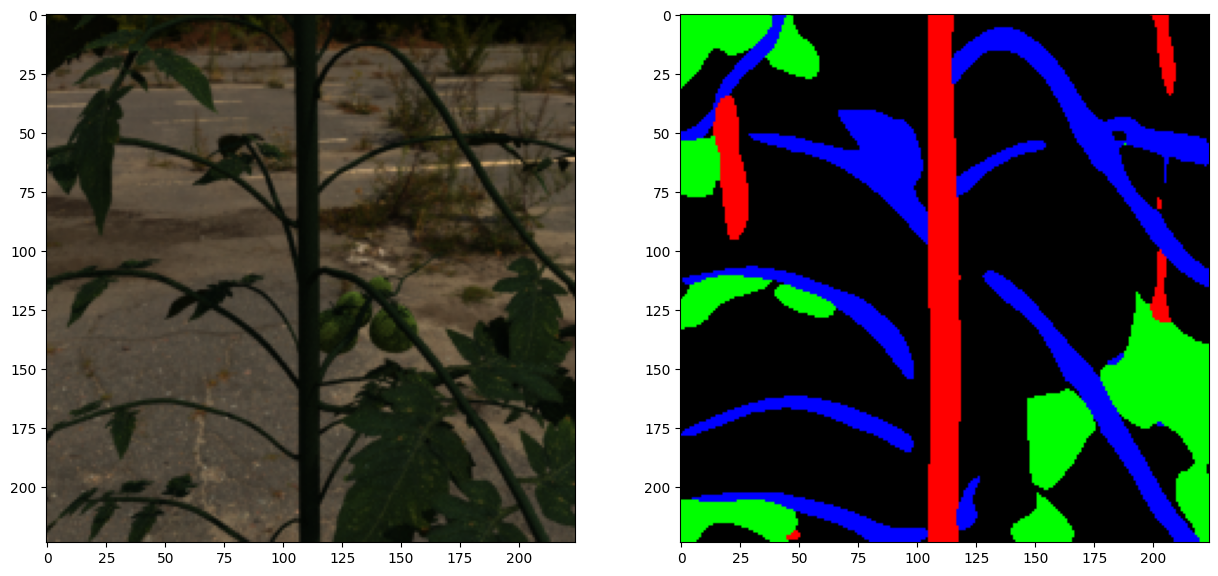

Original Image Shape: (224, 224, 3)
Predicted Shape: (224, 224, 5)
Class Pixels Shape: (224, 224, 5)
Colorized Output Shape: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


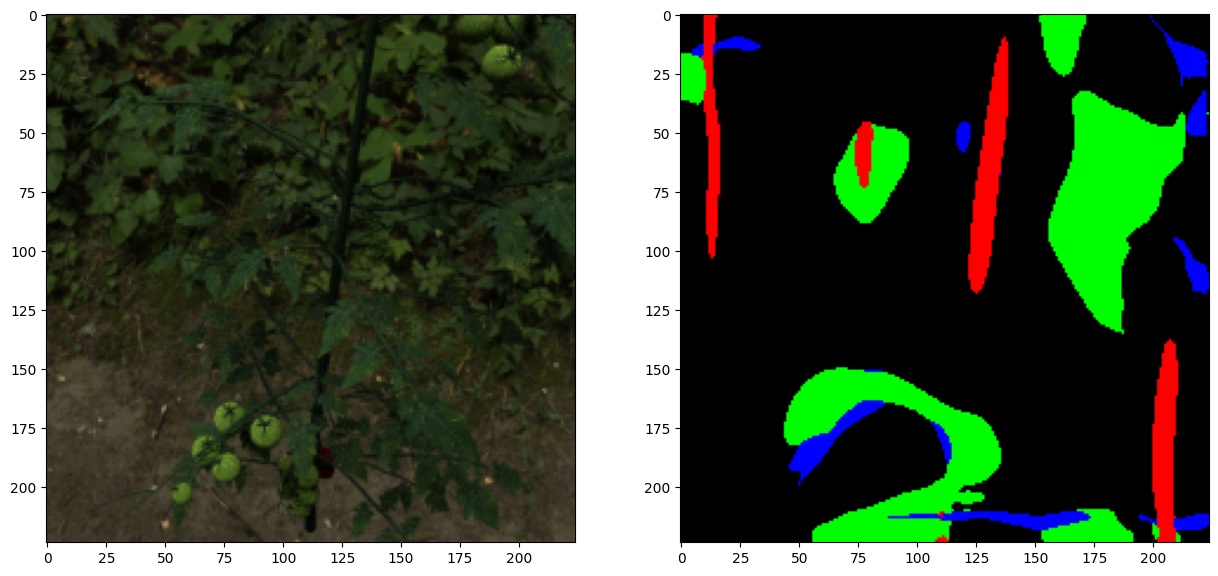

Original Image Shape: (224, 224, 3)
Predicted Shape: (224, 224, 5)
Class Pixels Shape: (224, 224, 5)
Colorized Output Shape: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


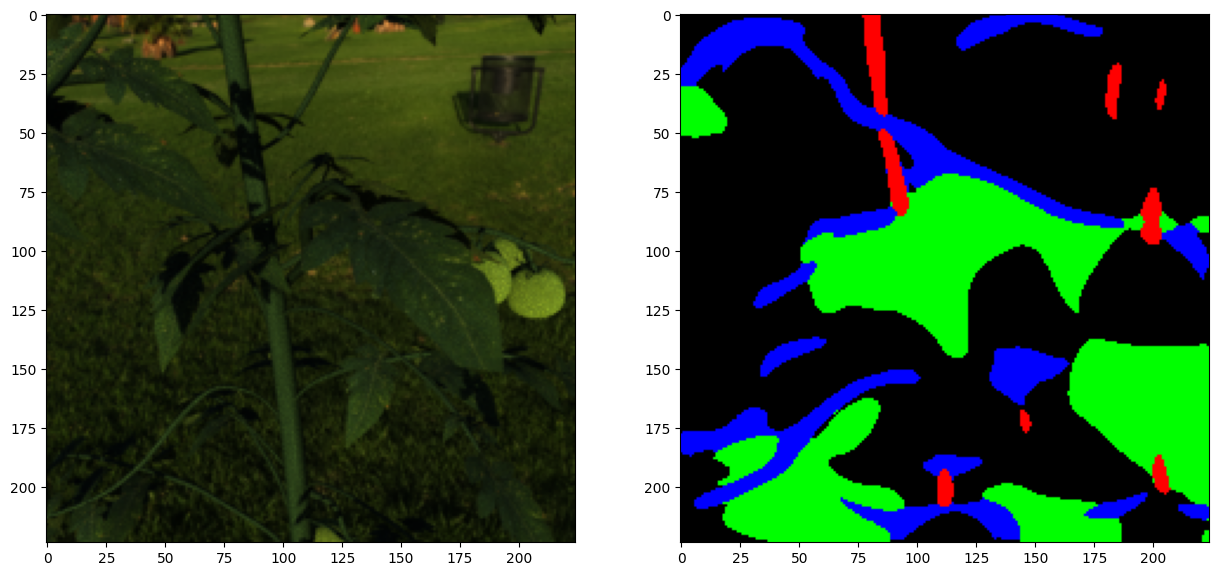

Original Image Shape: (224, 224, 3)
Predicted Shape: (224, 224, 5)
Class Pixels Shape: (224, 224, 5)
Colorized Output Shape: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


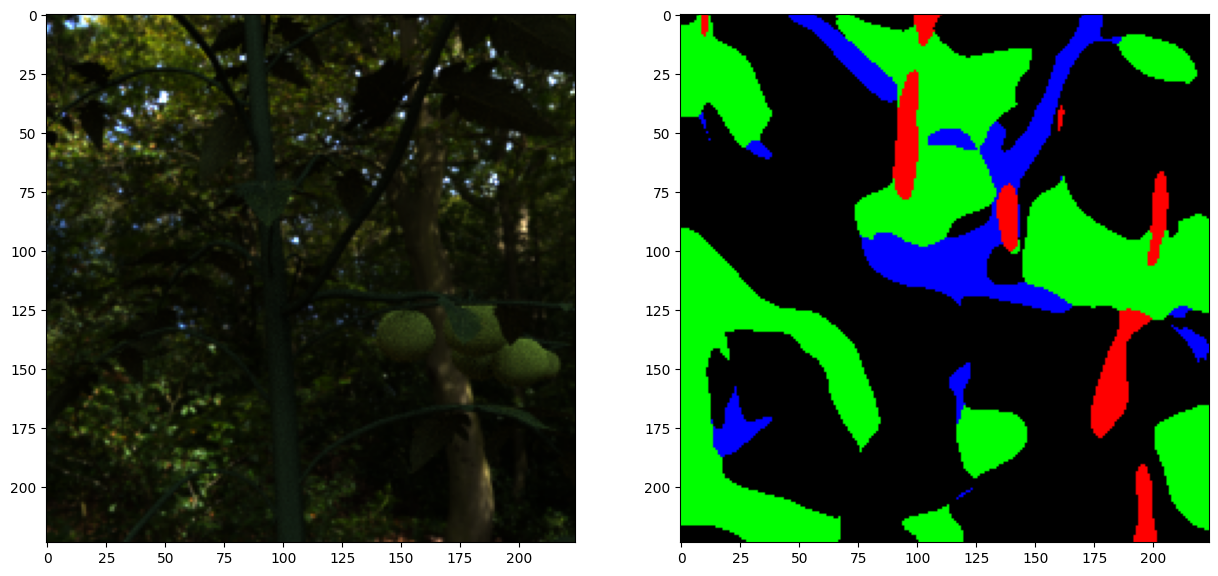

Original Image Shape: (224, 224, 3)
Predicted Shape: (224, 224, 5)
Class Pixels Shape: (224, 224, 5)
Colorized Output Shape: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


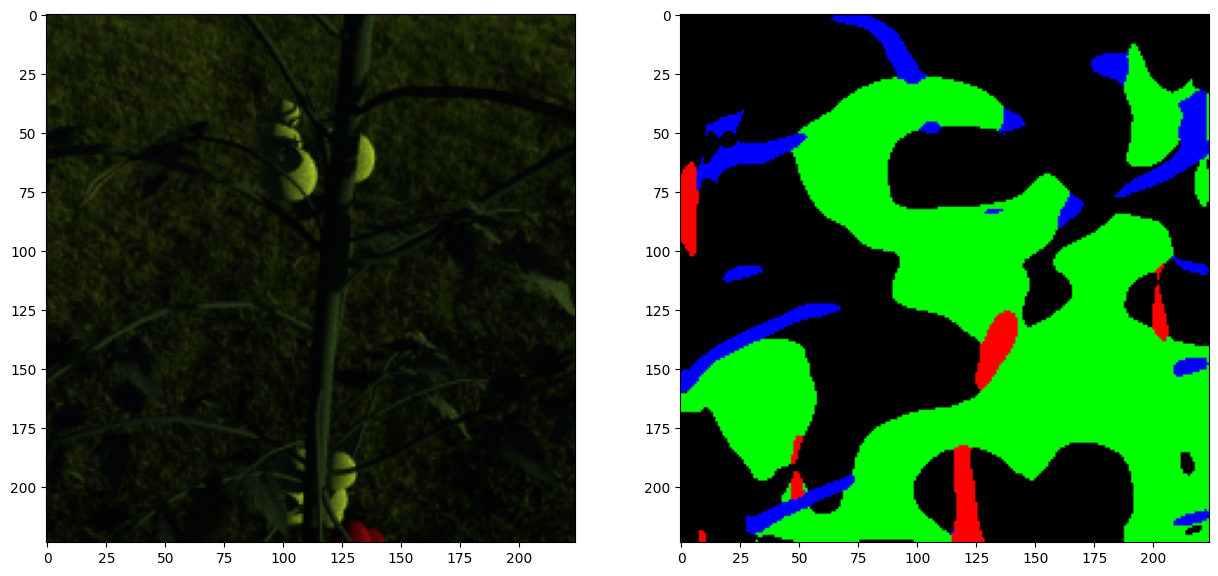

Original Image Shape: (224, 224, 3)
Predicted Shape: (224, 224, 5)
Class Pixels Shape: (224, 224, 5)
Colorized Output Shape: (224, 224, 3)


In [ ]:
h=0
for i in test_list:
    if h<10:

        img_path = rgb[i]
        original_img = convert_exr_to_rgb(img_path)
        # original_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/res.png')
        # original_img = original_img[:224,:224,[2,1,0]]

        plt.figure(figsize=(15,15))
        plt.subplot(1,2,1)
        plt.imshow(original_img)
        array_img=img_to_array(original_img)/255

        array_img2 = np.reshape(array_img, (1,224,224,3))
        y_pred=model.predict(array_img2)
        y_pred = np.reshape(y_pred[0], (224, 224, 5))
        c=class_pixels(y_pred)
        o=colorize(c)
        plt.subplot(1,2,2)
        plt.imshow(o)
        plt.show()
        h+=1
        print("Original Image Shape:", array_img.shape)
        print("Predicted Shape:", y_pred.shape)
        print("Class Pixels Shape:", c.shape)
        print("Colorized Output Shape:", o.shape)

    else:
        break